* `Import Libraries`

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import scipy.stats as stats

# sklearn - preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder , MinMaxScaler , RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# sklearn - metrics
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_squared_log_error , r2_score

# Tensorflow - models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

* `Reading and Understanding Dataset`

In [46]:
# Using pandas
FILE_PATH = os.path.join(os.getcwd(), 'combined_sorted_crime_data.csv')
df = pd.read_csv(FILE_PATH)
df.head()

,Country,Year,Gender_Female,Gender_Male,Gender_Total,Age_Under18,Age_Over18,Age_Total,VALUE
0,Albania,1992-01-01,0,0,1,0,0,1,130
1,Albania,1992-01-01,0,1,0,0,0,1,116
2,Albania,1992-01-01,1,0,0,0,0,1,14
3,Albania,1993-01-01,0,0,1,0,0,1,191
4,Albania,1993-01-01,0,1,0,0,0,1,175


In [47]:
df.shape

(107090, 9)

In [48]:
df.dtypes

Country          object
Year             object
Gender_Female     int64
Gender_Male       int64
Gender_Total      int64
Age_Under18       int64
Age_Over18        int64
Age_Total         int64
VALUE             int64
dtype: object

In [49]:
df.info()  # info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107090 entries, 0 to 107089
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Country        107090 non-null  object
 1   Year           107090 non-null  object
 2   Gender_Female  107090 non-null  int64 
 3   Gender_Male    107090 non-null  int64 
 4   Gender_Total   107090 non-null  int64 
 5   Age_Under18    107090 non-null  int64 
 6   Age_Over18     107090 non-null  int64 
 7   Age_Total      107090 non-null  int64 
 8   VALUE          107090 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 7.4+ MB


In [50]:
# stats
df.describe()

,Gender_Female,Gender_Male,Gender_Total,Age_Under18,Age_Over18,Age_Total,VALUE
count,107090.000000,107090.000000,107090.000000,107090.000000,107090.000000,107090.000000,107090.000000
mean,0.275367,0.278289,0.446344,0.128705,0.234448,0.636848,775.582482
std,0.446701,0.448159,0.497115,0.334875,0.423655,0.480911,9690.242068
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,57.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,566603.000000


* `Exploratory Data Analysis ==> EDA`

In [51]:
df.isna().sum()

Country          0
Year             0
Gender_Female    0
Gender_Male      0
Gender_Total     0
Age_Under18      0
Age_Over18       0
Age_Total        0
VALUE            0
dtype: int64

In [52]:
df.duplicated().sum()

32424

In [53]:
df.drop_duplicates(inplace=True)

In [54]:
df.duplicated().sum()

0

In [55]:
df.shape

(74666, 9)

In [56]:
df['Year'] = pd.to_datetime(df['Year'])
df = df.sort_values(by='Year')

In [57]:
for country in df['Country'].unique():
    max_year = df[df['Country'] == country]['Year'].max()
    print(f"{country}: {max_year}")

Singapore: 2022-01-01 00:00:00
Bhutan: 2020-01-01 00:00:00
Costa Rica: 2023-01-01 00:00:00
Malta: 2023-01-01 00:00:00
Norway: 2022-01-01 00:00:00
Mauritius: 2022-01-01 00:00:00
Nicaragua: 2021-01-01 00:00:00
Bosnia and Herzegovina: 2022-01-01 00:00:00
France: 2023-01-01 00:00:00
Estonia: 2022-01-01 00:00:00
Japan: 2022-01-01 00:00:00
Azerbaijan: 2022-01-01 00:00:00
Bahamas: 2022-01-01 00:00:00
Jamaica: 2022-01-01 00:00:00
Republic of Moldova: 2023-01-01 00:00:00
Denmark: 2022-01-01 00:00:00
Morocco: 2023-01-01 00:00:00
Russian Federation: 2021-01-01 00:00:00
Netherlands (Kingdom of the): 2022-01-01 00:00:00
Georgia: 2020-01-01 00:00:00
Jordan: 2023-01-01 00:00:00
Slovenia: 2022-01-01 00:00:00
Belarus: 2020-01-01 00:00:00
Uruguay: 2022-01-01 00:00:00
Lithuania: 2022-01-01 00:00:00
Croatia: 2022-01-01 00:00:00
United Kingdom (England and Wales): 2022-01-01 00:00:00
China, Hong Kong Special Administrative Region: 2022-01-01 00:00:00
Australia: 2022-01-01 00:00:00
Philippines: 2020-01-01 0

In [58]:
# # Plot Time Series Analysis for all numeric columns
# numeric_cols = df.select_dtypes(include=[np.number]).columns
# for col in numeric_cols:
#     plt.figure(figsize=(12, 6))
#     sns.lineplot(x=df['Year'], y=df[col], label=f"{col} over Time")
#     plt.title(f"Time Series of {col}")
#     plt.xlabel("Year")
#     plt.ylabel(col)
#     plt.legend()
#     plt.show()

In [59]:
# # Plot Gender Distribution
# df.groupby("Year")[["Gender_Female", "Gender_Male"]].sum().plot(figsize=(12, 6))
# plt.title("Gender Distribution Over Time")
# plt.show()


In [60]:
# # Plot Age Distribution
# df.groupby("Year")[["Age_Under18", "Age_Over18"]].sum().plot(figsize=(12, 6))
# plt.title("Age Distribution Over Time")
# plt.show()

In [61]:
df['Year'] = df['Year'].dt.year
df['Year']

85808    1990
13275    1990
23613    1990
61306    1990
73202    1990
         ... 
24660    2023
67586    2023
55820    2023
62682    2023
67587    2023
Name: Year, Length: 74666, dtype: int32

In [62]:
df.head()

,Country,Year,Gender_Female,Gender_Male,Gender_Total,Age_Under18,Age_Over18,Age_Total,VALUE
85808,Singapore,1990,0,0,1,0,0,1,47
13275,Bhutan,1990,0,0,1,0,0,1,20
23613,Costa Rica,1990,0,0,1,0,0,1,139
61306,Malta,1990,0,0,1,0,0,1,4
73202,Norway,1990,0,0,1,0,0,1,47


In [63]:
df.info()  # info

<class 'pandas.core.frame.DataFrame'>
Index: 74666 entries, 85808 to 67587
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country        74666 non-null  object
 1   Year           74666 non-null  int32 
 2   Gender_Female  74666 non-null  int64 
 3   Gender_Male    74666 non-null  int64 
 4   Gender_Total   74666 non-null  int64 
 5   Age_Under18    74666 non-null  int64 
 6   Age_Over18     74666 non-null  int64 
 7   Age_Total      74666 non-null  int64 
 8   VALUE          74666 non-null  int64 
dtypes: int32(1), int64(7), object(1)
memory usage: 5.4+ MB


In [64]:
Q1 = df['Year'].quantile(0.25)
Q3 = df['Year'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Year'] >= lower_bound) & (df['Year'] <= upper_bound)]

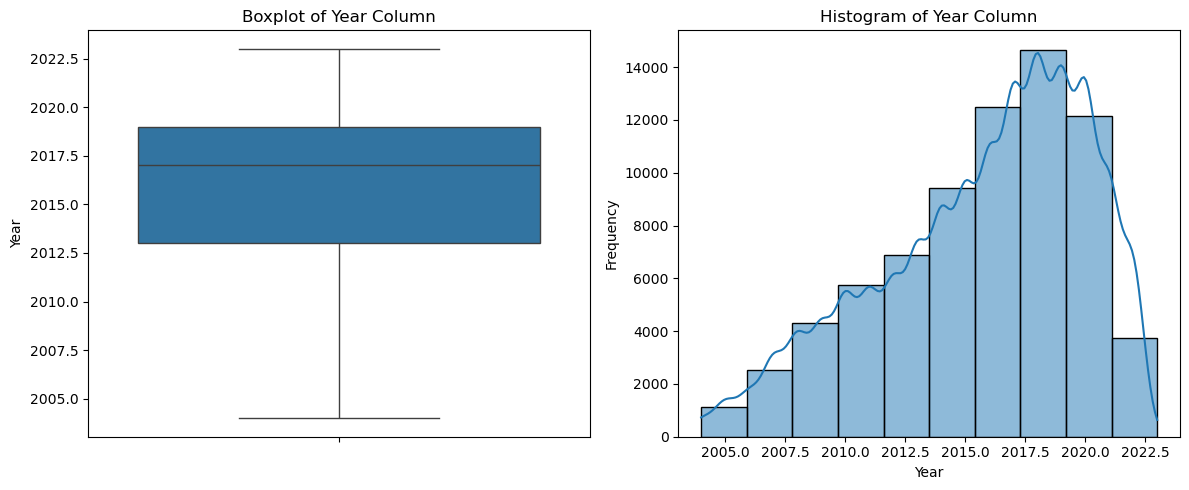

In [65]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df["Year"])
plt.title("Boxplot of Year Column")
plt.ylabel("Year")

plt.subplot(1, 2, 2)
sns.histplot(df["Year"], bins=10, kde=True)
plt.title("Histogram of Year Column")
plt.xlabel("Year")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [66]:
future_years = list(range(2023, 2028))
min_year = df['Year'].min()
max_year = max(df['Year'].max(), max(future_years))

In [67]:
Q1 = df['VALUE'].quantile(0.25)
Q3 = df['VALUE'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['VALUE'] >= lower_bound) & (df['VALUE'] <= upper_bound)]

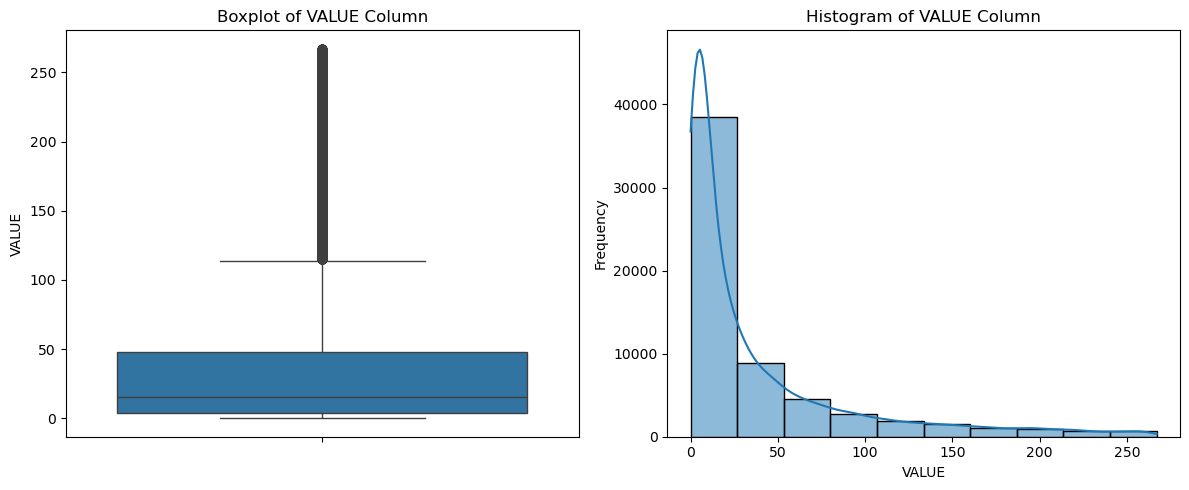

In [68]:
# Log transform
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df["VALUE"])
plt.title("Boxplot of VALUE Column")
plt.ylabel("VALUE")

plt.subplot(1, 2, 2)
sns.histplot(df["VALUE"], bins=10, kde=True)
plt.title("Histogram of VALUE Column")
plt.xlabel("VALUE")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [69]:
num_countries = df['Country'].nunique()
print(f"Total unique countries: {num_countries}")

country_counts = df['Country'].value_counts()
print("Number of occurrences per country:")
for country, count in country_counts.items():
    print(f"{country}: {count}")

Total unique countries: 142
Number of occurrences per country:
Canada: 1253
Germany: 1152
Spain: 1104
Switzerland: 1095
Austria: 1055
Hungary: 1049
Finland: 1039
Lithuania: 1026
Italy: 1025
Czechia: 942
Colombia: 931
Mongolia: 882
Slovakia: 882
Serbia: 878
El Salvador: 853
Chile: 819
Bolivia (Plurinational State of): 813
Uruguay: 804
Australia: 790
Latvia: 782
Slovenia: 762
Guyana: 759
Croatia: 758
Dominican Republic: 749
Ecuador: 729
Panama: 727
Bahamas: 720
Honduras: 702
Netherlands (Kingdom of the): 694
Albania: 684
France: 682
Türkiye: 676
Denmark: 676
Costa Rica: 666
Jamaica: 651
Trinidad and Tobago: 649
Norway: 646
Greece: 640
Argentina: 604
Bulgaria: 602
United Kingdom (Scotland): 579
Azerbaijan: 577
Bosnia and Herzegovina: 546
Mexico: 543
United Kingdom (England and Wales): 537
Japan: 529
Peru: 513
Belarus: 512
Armenia: 507
Republic of Moldova: 504
Ireland: 496
Poland: 486
Jordan: 484
Guatemala: 482
Sri Lanka: 475
Barbados: 467
Morocco: 466
Montenegro: 465
Belize: 464
Cyprus: 4

In [70]:
groups = [df[df['Country'] == country]['VALUE'] for country in df['Country'].unique()]

f_stat, p_value = stats.f_oneway(*groups)

print("ANOVA F-Statistic:", f_stat)
print("P-value:", p_value)

# Interpretation
if p_value < 0.05:
    print(" 'Country' significantly affects 'VALUE'!")
else:
    print("No strong evidence that 'Country' affects 'VALUE'.")


ANOVA F-Statistic: 68.66913793028765
P-value: 0.0
 'Country' significantly affects 'VALUE'!


In [71]:
threshold = 200
valid_countries = country_counts[country_counts > threshold].index

df = df[df['Country'].isin(valid_countries)]

print(f"Remaining countries: {df['Country'].nunique()}")

Remaining countries: 103


* `Splitting Dataset to train & test`

In [72]:
num_countries = df['Country'].nunique()
print(f"Total unique countries: {num_countries}")

country_counts = df['Country'].value_counts()
print("Number of occurrences per country:")
for country, count in country_counts.items():
    print(f"{country}: {count}")

Total unique countries: 103
Number of occurrences per country:
Canada: 1253
Germany: 1152
Spain: 1104
Switzerland: 1095
Austria: 1055
Hungary: 1049
Finland: 1039
Lithuania: 1026
Italy: 1025
Czechia: 942
Colombia: 931
Mongolia: 882
Slovakia: 882
Serbia: 878
El Salvador: 853
Chile: 819
Bolivia (Plurinational State of): 813
Uruguay: 804
Australia: 790
Latvia: 782
Slovenia: 762
Guyana: 759
Croatia: 758
Dominican Republic: 749
Ecuador: 729
Panama: 727
Bahamas: 720
Honduras: 702
Netherlands (Kingdom of the): 694
Albania: 684
France: 682
Türkiye: 676
Denmark: 676
Costa Rica: 666
Jamaica: 651
Trinidad and Tobago: 649
Norway: 646
Greece: 640
Argentina: 604
Bulgaria: 602
United Kingdom (Scotland): 579
Azerbaijan: 577
Bosnia and Herzegovina: 546
Mexico: 543
United Kingdom (England and Wales): 537
Japan: 529
Peru: 513
Belarus: 512
Armenia: 507
Republic of Moldova: 504
Ireland: 496
Poland: 486
Jordan: 484
Guatemala: 482
Sri Lanka: 475
Barbados: 467
Morocco: 466
Montenegro: 465
Belize: 464
Cyprus: 4

In [73]:
# Split X & y
X = df.drop(columns=['VALUE'], axis=1)
y = df['VALUE']

y.value_counts(normalize=True)

VALUE
4      0.105146
0      0.059856
1      0.042003
5      0.033749
2      0.033679
         ...   
240    0.000280
265    0.000280
266    0.000280
230    0.000280
247    0.000262
Name: proportion, Length: 268, dtype: float64

In [74]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train, test in tscv.split(X):  
    X_train, X_test = X.iloc[train], X.iloc[test]  
    y_train, y_test = y.iloc[train], y.iloc[test] 

In [75]:
# Split to train & test folds
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=45, shuffle=False)

## Check shapes
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('***'*10)
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (47656, 8)
y_train.shape 	 (47656,)
******************************
X_test.shape 	 (9531, 8)
y_test.shape 	 (9531,)


* `Data Preprocessing & Pipeline`

In [76]:
X_train.columns

Index(['Country', 'Year', 'Gender_Female', 'Gender_Male', 'Gender_Total',
       'Age_Under18', 'Age_Over18', 'Age_Total'],
      dtype='object')

In [77]:
for i in X_train.columns:
    if X_train[i].dtype=='object':
        print(i)

Country


In [78]:
# Slice lists for each col type
num_cols = ['Year']
categ_cols = ['Country']
ready_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(categ_cols))
ready_cols

['Age_Under18',
 'Age_Total',
 'Age_Over18',
 'Gender_Male',
 'Gender_Female',
 'Gender_Total']

In [79]:
# Pipeline

# For Numerical
num_pipeline = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='median')),
                    ('log', FunctionTransformer(np.log1p, validate=False)),
                    ('scaler', MinMaxScaler())
                ])


# For Categorical
categ_pipeline = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ohe', OneHotEncoder(sparse_output=False, drop='first'))
                ])


# For Ready Cols
ready_pipeline = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                ])



# Combine all secondary pipelines into one total pipeline
all_pipeline = ColumnTransformer(transformers=[
                    ('numerical', num_pipeline, num_cols),
                    ('categorical', categ_pipeline, categ_cols),
                    ('ready', ready_pipeline, ready_cols)
                ])


# Apply
X_train_final = all_pipeline.fit_transform(X_train)
X_test_final = all_pipeline.transform(X_test)

In [80]:
X_train_final

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [81]:
# Check train
X_train_final.shape, y_train.shape

((47656, 109), (47656,))

In [82]:
# Check test
X_test_final.shape, y_test.shape

((9531, 109), (9531,))

In [83]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))


In [84]:
timesteps = 1
features_per_timestep = X_train_final.shape[1] // timesteps  

# Reshape X_train and X_test
X_train_final = X_train_final.reshape(X_train_final.shape[0], timesteps, features_per_timestep)
X_test_final = X_test_final.reshape(X_test_final.shape[0], timesteps, features_per_timestep)

print(X_train_final.shape, X_test_final.shape)  

(47656, 1, 109) (9531, 1, 109)


* LSTM Models

In [85]:
model = Sequential([
    LSTM(256, return_sequences=True,input_shape=(timesteps, features_per_timestep)),
    BatchNormalization(),
    Dropout(0.25),

    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

C:\Users\hp\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 256)              │         374,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 583,809 (2.23 MB)

 Trainable params: 583,041 (2.22 MB)

 Non-trainable params: 768 (3.00 KB)

In [86]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train Model
history = model.fit(
    X_train_final, y_train_scaled,
    validation_data=(X_test_final, y_test_scaled),
    epochs=20,
    batch_size=128,  
    callbacks=[early_stopping],
    verbose=1

)

Epoch 1/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.1055 - val_loss: 0.0479
Epoch 2/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0378 - val_loss: 0.0338
Epoch 3/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0353 - val_loss: 0.0339
Epoch 4/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0343 - val_loss: 0.0324
Epoch 5/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0340 - val_loss: 0.0362
Epoch 6/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0331 - val_loss: 0.0331
Epoch 7/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0331 - val_loss: 0.0329
Epoch 8/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0331 - val_loss: 0.0338
Epoch 9/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0325 - val_loss: 0.0322
Epoch 10/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0322 - val_loss: 0.0324
Epoch 11/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0329 - val_loss: 0.0326
Epoch 12/20
373/373 ━━━━━━━━━━━━━━━━━━━━

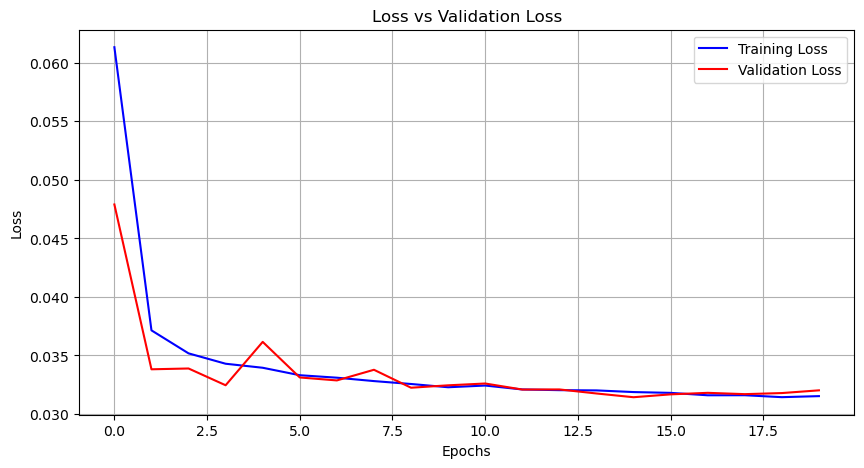

In [87]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

* inferance

In [88]:
y_pred_lstm_train = model.predict(X_train_final)
y_pred_lstm_test = model.predict(X_test_final)

MSE_LSTM_Train = mean_squared_error(y_train_scaled,y_pred_lstm_train)
MSE_LSTM_Test = mean_squared_error(y_test_scaled,y_pred_lstm_test)

print(f"MSE_LSTM_TRAIN: {MSE_LSTM_Train:.2f}")
print(f"MSE_LSTM_TEST: {MSE_LSTM_Test:.2f}")


1490/1490 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE_LSTM_TRAIN: 0.03
MSE_LSTM_TEST: 0.03


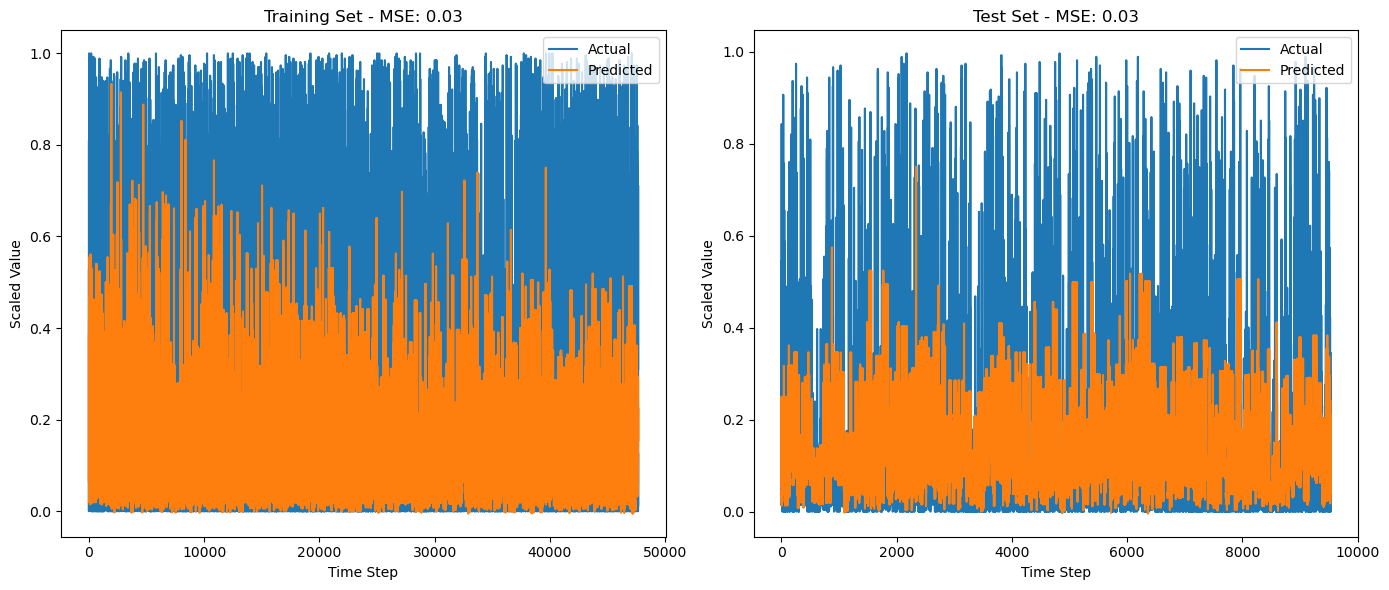

In [89]:
y_pred_lstm_train = y_pred_lstm_train.flatten()
y_pred_lstm_test = y_pred_lstm_test.flatten()
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

# Plot
plt.figure(figsize=(14, 6))

# Training set
plt.subplot(1, 2, 1)
plt.plot(y_train_scaled, label='Actual')
plt.plot(y_pred_lstm_train, label='Predicted')
plt.title(f'Training Set - MSE: {MSE_LSTM_Train:.2f}')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()

# Test set
plt.subplot(1, 2, 2)
plt.plot(y_test_scaled, label='Actual')
plt.plot(y_pred_lstm_test, label='Predicted')
plt.title(f'Test Set - MSE: {MSE_LSTM_Test:.2f}')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()

plt.tight_layout()
plt.show()

In [92]:
from sklearn.metrics import root_mean_squared_error

y_pred_lstm_train = model.predict(X_train_final)
y_pred_lstm_test = model.predict(X_test_final)

RMSE_LSTM_Train = root_mean_squared_error(y_train_scaled,y_pred_lstm_train)
RMSE_LSTM_Test = root_mean_squared_error(y_test_scaled,y_pred_lstm_test)

print(f"RMSE_LSTM_TRAIN: {RMSE_LSTM_Train:.2f}")
print(f"RMSE_LSTM_TEST: {RMSE_LSTM_Test:.2f}")


1490/1490 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE_LSTM_TRAIN: 0.17
RMSE_LSTM_TEST: 0.18


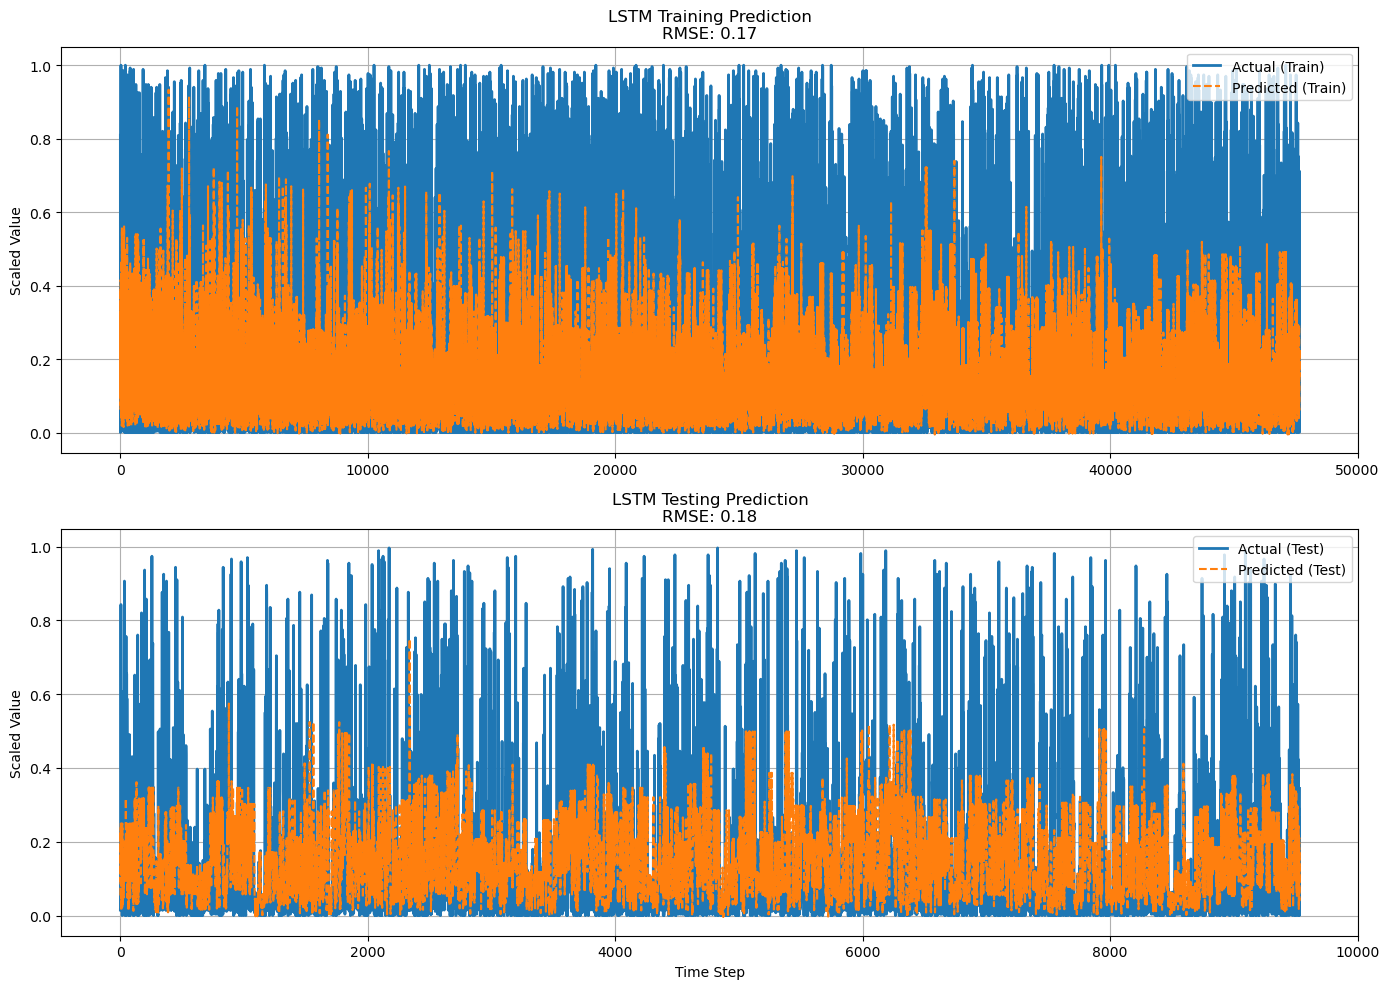

In [93]:
y_pred_lstm_train = y_pred_lstm_train.flatten()
y_pred_lstm_test = y_pred_lstm_test.flatten()
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Plot training data
axes[0].plot(y_train_scaled, label='Actual (Train)', linewidth=2)
axes[0].plot(y_pred_lstm_train, label='Predicted (Train)', linestyle='--')
axes[0].set_title(f'LSTM Training Prediction\nRMSE: {RMSE_LSTM_Train:.2f}')
axes[0].set_ylabel('Scaled Value')
axes[0].legend()
axes[0].grid(True)

# Plot testing data
axes[1].plot(y_test_scaled, label='Actual (Test)', linewidth=2)
axes[1].plot(y_pred_lstm_test, label='Predicted (Test)', linestyle='--')
axes[1].set_title(f'LSTM Testing Prediction\nRMSE: {RMSE_LSTM_Test:.2f}')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Scaled Value')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [96]:

y_pred_lstm_train = model.predict(X_train_final)
y_pred_lstm_test = model.predict(X_test_final)

MAE_LSTM_Train = mean_absolute_error(y_train_scaled,y_pred_lstm_train)
MAE_LSTM_Test = mean_absolute_error(y_test_scaled,y_pred_lstm_test)

print(f"MAE_LSTM_TRAIN: {MAE_LSTM_Train:.2f}")
print(f"MAE_LSTM_TEST: {MAE_LSTM_Test:.2f}")


1490/1490 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
MAE_LSTM_TRAIN: 0.12
MAE_LSTM_TEST: 0.12


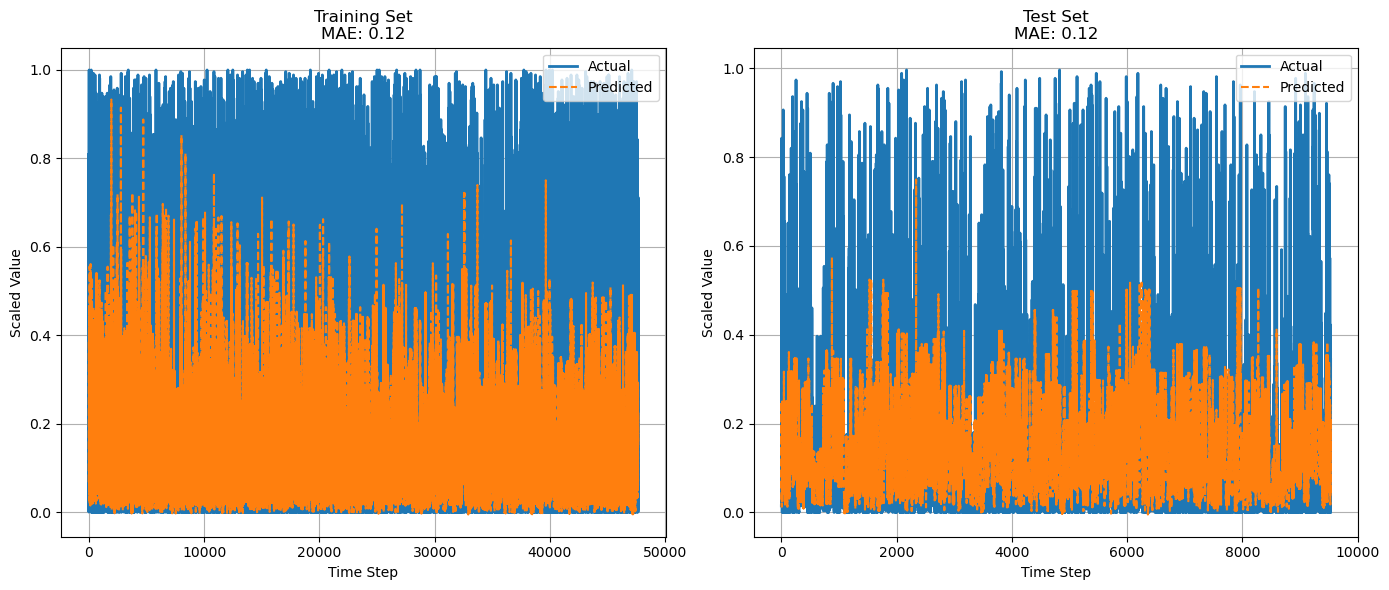

In [97]:
y_pred_lstm_train = y_pred_lstm_train.flatten()
y_pred_lstm_test = y_pred_lstm_test.flatten()
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

# Plot
plt.figure(figsize=(14, 6))

# Training data
plt.subplot(1, 2, 1)
plt.plot(y_train_scaled, label='Actual', linewidth=2)
plt.plot(y_pred_lstm_train, label='Predicted', linestyle='--')
plt.title(f'Training Set\nMAE: {MAE_LSTM_Train:.2f}')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)

# Testing data
plt.subplot(1, 2, 2)
plt.plot(y_test_scaled, label='Actual', linewidth=2)
plt.plot(y_pred_lstm_test, label='Predicted', linestyle='--')
plt.title(f'Test Set\nMAE: {MAE_LSTM_Test:.2f}')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [46]:
%%capture
!pip install matplotlib seaborn

In [47]:
sample_size = 1000  
y_true_sample = y_test_scaled[:sample_size]
y_pred_sample = y_pred_lstm_test[:sample_size].flatten()
residuals_sample = y_true_sample - y_pred_sample

* Loop over all unique Countries For All Possible Values 

In [51]:
all_future_countries_predictions = pd.DataFrame()
def get_predictions_with_historical_ratios(country_name, start_year, end_year):
    global all_future_countries_predictions

    country_df = df[df['Country'] == country_name]
    avg_values = country_df[['Gender_Female', 'Gender_Male', 'Gender_Total',
                             'Age_Under18', 'Age_Over18', 'Age_Total']].mean()

    data = []
    for year in range(start_year, end_year + 1):
        factor = 1 + 0.02 * (year - start_year)  # 2% change per year

        new_data = pd.DataFrame([{
            "Country": country_name,
            "Year": year,
            "Gender_Female": avg_values['Gender_Female'] * factor,
            "Gender_Male": avg_values['Gender_Male'] * factor,
            "Gender_Total": avg_values['Gender_Total'] * factor,
            "Age_Under18": avg_values['Age_Under18'] * factor,
            "Age_Over18": avg_values['Age_Over18'] * factor,
            "Age_Total": avg_values['Age_Total'] * factor,
        }])

        X_new = all_pipeline.transform(new_data)
        X_new = X_new.reshape(1, 1, features_per_timestep)
        y_pred_scaled = model.predict(X_new, verbose=0)
        y_pred_actual = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

        data.append({
            'Country': country_name,
            'Year': year,
            **new_data.iloc[0].to_dict(),
            'Predicted_VALUE': y_pred_actual[0][0]
        })

    country_predictions = pd.DataFrame(data)
    all_future_countries_predictions = pd.concat([all_future_countries_predictions, country_predictions], ignore_index=True)

    return country_predictions

ecuador_pred = get_predictions_with_historical_ratios("Ecuador", 2023, 2029)
print("Ecuador predictions finished")
ecuador_pred.head(10)

Ecuador predictions finished


,Country,Year,Gender_Female,Gender_Male,Gender_Total,Age_Under18,Age_Over18,Age_Total,Predicted_VALUE
0,Ecuador,2023,0.360768,0.279835,0.359396,0.157750,0.248285,0.593964,82.200188
1,Ecuador,2024,0.367984,0.285432,0.366584,0.160905,0.253251,0.605844,81.982330
2,Ecuador,2025,0.375199,0.291029,0.373772,0.164060,0.258217,0.617723,81.017387
3,Ecuador,2026,0.382414,0.296626,0.380960,0.167215,0.263182,0.629602,79.830391
4,Ecuador,2027,0.389630,0.302222,0.388148,0.170370,0.268148,0.641481,78.538177
5,Ecuador,2028,0.396845,0.307819,0.395336,0.173525,0.273114,0.653361,76.126823
6,Ecuador,2029,0.404060,0.313416,0.402524,0.176680,0.278080,0.665240,73.677139


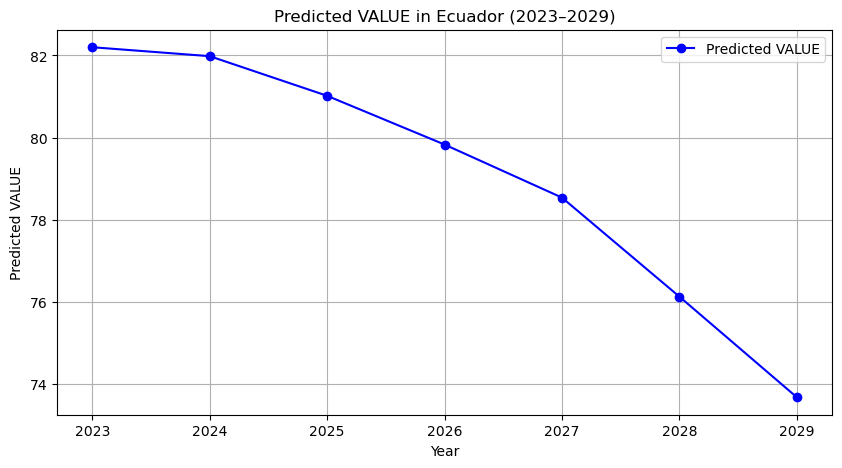

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(ecuador_pred["Year"], ecuador_pred["Predicted_VALUE"], marker='o', linestyle='-', color='blue', label="Predicted VALUE")
plt.title("Predicted VALUE in Ecuador (2023–2029)")
plt.xlabel("Year")
plt.ylabel("Predicted VALUE")
plt.grid(True)
plt.legend()
plt.show()


In [53]:
pd.set_option('display.max_rows', None)
all_future_countries_predictions

,Country,Year,Gender_Female,Gender_Male,Gender_Total,Age_Under18,Age_Over18,Age_Total,Predicted_VALUE
0,Ecuador,2023,0.360768,0.279835,0.359396,0.157750,0.248285,0.593964,82.200188
1,Ecuador,2024,0.367984,0.285432,0.366584,0.160905,0.253251,0.605844,81.982330
2,Ecuador,2025,0.375199,0.291029,0.373772,0.164060,0.258217,0.617723,81.017387
3,Ecuador,2026,0.382414,0.296626,0.380960,0.167215,0.263182,0.629602,79.830391
4,Ecuador,2027,0.389630,0.302222,0.388148,0.170370,0.268148,0.641481,78.538177
5,Ecuador,2028,0.396845,0.307819,0.395336,0.173525,0.273114,0.653361,76.126823
6,Ecuador,2029,0.404060,0.313416,0.402524,0.176680,0.278080,0.665240,73.677139


In [55]:
ecuador_pred = get_predictions_with_historical_ratios("Germany", 2023, 2029)
print("Germany finished")
ecuador_pred = get_predictions_with_historical_ratios("Barbados", 2023, 2029)
print("Barbados predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Denmark", 2023, 2029)
print("Denmark predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("France", 2024, 2029)
print("France predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("United Kingdom (England and Wales)", 2023, 2029)
print("United Kingdom (England and Wales) predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Russian Federation", 2022, 2029)
print("Russian Federation predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Saint Lucia", 2023, 2029)
print("Saint Lucia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Mexico", 2024, 2029)
print("Mexico predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Republic of Moldova", 2023, 2029)
print("Republic of Moldova predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Japan", 2023, 2029)
print("Japan predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Cyprus", 2024, 2029)
print("Cyprus predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Australia", 2023, 2029)
print("Australia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Hungary", 2024, 2029)
print("Hungary predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Slovenia", 2023, 2029)
print("Slovenia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Finland", 2023, 2029)
print("Finland predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Netherlands (Kingdom of the)", 2023, 2029)
print("Netherlands predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Lithuania", 2023, 2029)
print("Lithuania predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Bulgaria", 2023, 2029)
print("Bulgaria predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Switzerland", 2023, 2029)
print("Switzerland predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Georgia", 2021, 2029)
print("Georgia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Malta", 2024, 2029)
print("Malta predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Uzbekistan", 2022, 2029)
print("Uzbekistan predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Norway", 2023, 2029)
print("Norway predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Italy", 2023, 2029)
print("Italy predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Egypt", 2022, 2029)
print("Egypt predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Canada", 2023, 2029)
print("Canada predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Bosnia and Herzegovina", 2023, 2029)
print("Bosnia and Herzegovina predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Saint Vincent and the Grenadines", 2023, 2029)
print("Saint Vincent and the Grenadines predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Croatia", 2023, 2029)
print("Croatia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Armenia", 2022, 2029)
print("Armenia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Singapore", 2023, 2029)
print("Singapore predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Uruguay", 2023, 2029)
print("Uruguay predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Philippines", 2021, 2029)
print("Philippines predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Slovakia", 2024, 2029)
print("Slovakia predictions finished")

Germany finished
Barbados predictions finished
Denmark predictions finished
France predictions finished
United Kingdom (England and Wales) predictions finished
Russian Federation predictions finished
Saint Lucia predictions finished
Mexico predictions finished
Republic of Moldova predictions finished
Japan predictions finished
Cyprus predictions finished
Australia predictions finished
Hungary predictions finished
Slovenia predictions finished
Finland predictions finished
Netherlands predictions finished
Lithuania predictions finished
Bulgaria predictions finished
Switzerland predictions finished
Georgia predictions finished
Malta predictions finished
Uzbekistan predictions finished
Norway predictions finished
Italy predictions finished
Egypt predictions finished
Canada predictions finished
Bosnia and Herzegovina predictions finished
Saint Vincent and the Grenadines predictions finished
Croatia predictions finished
Armenia predictions finished
Singapore predictions finished
Uruguay pred

In [56]:
ecuador_pred = get_predictions_with_historical_ratios("Romania", 2023, 2029)
print("Romania predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Austria", 2023, 2029)
print("Austria predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Morocco", 2024, 2029)
print("Morocco predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Greece", 2023, 2029)
print("Greece predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Jamaica", 2023, 2029)
print("Jamaica predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Costa Rica", 2024, 2029)
print("Costa Rica predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Mauritius", 2023, 2029)
print("Mauritius predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Belarus", 2021, 2029)
print("Belarus predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Qatar", 2023, 2029)
print("Qatar predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Colombia", 2023, 2029)
print("Colombia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("China, Hong Kong Special Administrative Region", 2023, 2029)
print("China, Hong Kong predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Sri Lanka", 2022, 2029)
print("Sri Lanka predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Ireland", 2023, 2029)
print("Ireland predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Bahamas", 2023, 2029)
print("Bahamas predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Sweden", 2023, 2029)
print("Sweden predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Guyana", 2023, 2029)
print("Guyana predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Jordan", 2024, 2029)
print("Jordan predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Estonia", 2023, 2029)
print("Estonia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Panama", 2023, 2029)
print("Panama predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Azerbaijan", 2023, 2029)
print("Azerbaijan predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("United States of America", 2023, 2029)
print("United States of America predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Poland", 2023, 2029)
print("Poland predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("United Kingdom (Northern Ireland)", 2023, 2029)
print("United Kingdom (Northern Ireland) predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Dominican Republic", 2023, 2029)
print("Dominican Republic predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("China, Macao Special Administrative Region", 2024, 2029)
print("China, Macao Region predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("United Kingdom (Scotland)", 2023, 2029)
print("United Kingdom (Scotland) predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Albania", 2023, 2029)
print("Albania predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Guatemala", 2022, 2029)
print("Guatemala predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Latvia", 2024, 2029)
print("Latvia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Luxembourg", 2023, 2029)
print("Luxembourg predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("El Salvador", 2023, 2029)
print("El Salvador predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Czechia", 2023, 2029)
print("Czechia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Belgium", 2022, 2029)
print("Belgium predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Iceland", 2023, 2029)
print("Iceland predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Spain", 2023, 2029)
print("Spain predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Portugal", 2023, 2029)
print("Portugal predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Honduras", 2023, 2029)
print("Honduras predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("New Zealand", 2022, 2029)
print("New Zealand predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Saint Kitts and Nevis", 2023, 2029)
print("Saint Kitts and Nevis predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Dominica", 2023, 2029)
print("Dominica predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("North Macedonia", 2023, 2029)
print("North Macedonia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Paraguay", 2023, 2029)
print("Paraguay predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Grenada", 2023, 2029)
print("Grenada predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Serbia", 2023, 2029)
print("Serbia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Suriname", 2023, 2029)
print("Suriname predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Belize", 2023, 2029)
print("Belize predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Trinidad and Tobago", 2023, 2029)
print("Trinidad and Tobago predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Argentina", 2023, 2029)
print("Argentina predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Oman", 2023, 2029)
print("Oman predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Montenegro", 2023, 2029)
print("Montenegro predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Mongolia", 2023, 2029)
print("Mongolia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("United Kingdom of Great Britain and Northern Ireland", 2022, 2029)
print("United Kingdom of Great Britain and Northern Ireland predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Türkiye", 2023, 2029)
print("Türkiye predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Kenya", 2023, 2029)
print("Kenya predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Bolivia (Plurinational State of)", 2024, 2029)
print("Bolivia predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Netherlands", 2021, 2029)
print("Netherlands predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Peru", 2023, 2029)
print("Peru predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Chile", 2023, 2029)
print("Chile predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Nigeria", 2022, 2029)
print("Nigeria predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Myanmar", 2023, 2029)
print("Myanmar predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Bahrain", 2022, 2029)
print("Bahrain predictions finished")


Romania predictions finished
Austria predictions finished
Morocco predictions finished
Greece predictions finished
Jamaica predictions finished
Costa Rica predictions finished
Mauritius predictions finished
Belarus predictions finished
Qatar predictions finished
Colombia predictions finished
China, Hong Kong predictions finished
Sri Lanka predictions finished
Ireland predictions finished
Bahamas predictions finished
Sweden predictions finished
Guyana predictions finished
Jordan predictions finished
Estonia predictions finished
Panama predictions finished
Azerbaijan predictions finished
United States of America predictions finished
Poland predictions finished
United Kingdom (Northern Ireland) predictions finished
Dominican Republic predictions finished
China, Macao Region predictions finished
United Kingdom (Scotland) predictions finished
Albania predictions finished
Guatemala predictions finished
Latvia predictions finished
Luxembourg predictions finished
El Salvador predictions finish

In [57]:
ecuador_pred = get_predictions_with_historical_ratios("Algeria", 2023, 2029)
print("Algeria predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Tajikistan", 2022, 2029)
print("Tajikistan predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Israel", 2022, 2029)
print("Israel predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("United Arab Emirates", 2021, 2029)
print("United Arab Emirates predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Thailand", 2022, 2029)
print("Thailand predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Lebanon", 2022, 2029)
print("Lebanon predictions finished")
ecuador_pred = get_predictions_with_historical_ratios("Malaysia", 2022, 2029)
print("Malaysia predictions finished")

Algeria predictions finished
Tajikistan predictions finished
Israel predictions finished
United Arab Emirates predictions finished
Thailand predictions finished
Lebanon predictions finished
Malaysia predictions finished


In [58]:
all_future_countries_predictions.head()

,Country,Year,Gender_Female,Gender_Male,Gender_Total,Age_Under18,Age_Over18,Age_Total,Predicted_VALUE
0,Ecuador,2023,0.360768,0.279835,0.359396,0.157750,0.248285,0.593964,82.200188
1,Ecuador,2024,0.367984,0.285432,0.366584,0.160905,0.253251,0.605844,81.982330
2,Ecuador,2025,0.375199,0.291029,0.373772,0.164060,0.258217,0.617723,81.017387
3,Ecuador,2026,0.382414,0.296626,0.380960,0.167215,0.263182,0.629602,79.830391
4,Ecuador,2027,0.389630,0.302222,0.388148,0.170370,0.268148,0.641481,78.538177


In [59]:
all_future_countries_predictions.to_csv('future_predictions.csv', index=False)